# Introduction
The general theme of today is to answer a simple question, is my hypothesis correct?  

Today we will focus on an easily simulated problem, the biased coin.  To motivate this example, consider a scenario where Mary recieves a coin which is a new and she wants to know whether or not it is biased.  She decides the best way to do this is to flip the coin $N$ times and empirically determined the probability of the coin landing on heads.  This makes sense, so lets think about the two limiting cases:

* If $N=1$, she flips the coin once and learns nothing about the coin. 
* If she flips the coin a massive amount of times ($N\to\infty$), she will know exactly (for $N\to\infty$) the probability getting heads and thus the bias of the coin.

Clearly the certainty of Mary's conclusion depends on two factors, the number of times she flips the coin $N$ and the resulting probability distribution from those flips.  Our goal in this lecture is to better quantify these notions and give some ideas about how they play into the question of whether her conclulsion is correct.

First lets import some packages we will need into the notebook.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set()

In [110]:
def random_coin_toss(n_tosses, bias):
    """
    function to compute a number of random coin tosses 
    with a biased coin
    
    Parameters
    ----------
        n_tosses int: number of tosses of the coin
        bias float[0,1]: bias of the coin
        
    Returns
    -------
       list of 0,1 values of length n_tosses where each value is chosen
       uniformly from [0,1] and compared against bias
    """

    return [1 if i > bias else 0 for i in np.random.rand(n_tosses)]

We can run an experiment where we we toss the coin ten thousand times for a few different biases and look at the probability of getting both heads and tails.  We can see that it is reasonably close to what we would expect.

*Question* : What would happen if we tossed the coin more?  Less?

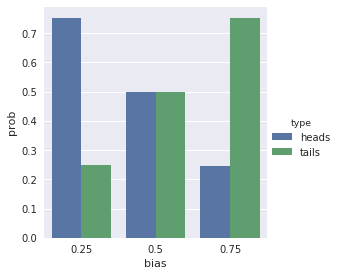

In [111]:
result = []
N = 10000
for bias in [.25,.5,.75]:
    tosses = random_coin_toss(N, bias)
    num_heads = len([i for i in tosses if i])
    result.append({'prob':num_heads/N,
                   'type':'heads',
                   'bias':bias})
    result.append({'prob':1-num_heads/N,
                  'type':'tails',
                  'bias':bias})
sns.factorplot(x='bias',y='prob',hue='type',
               data=pd.DataFrame(result),
               kind='bar')

So now we can ask the question, given a coin which may or may not be biased can we tell if it is biased or not?  Intuitively, if the coin is quite biased, this should be easier than if it is only slightly biased.  Of course we will generate all the data ourselves, so we can check easily check the accuracy of our results.

Lets say we have flipped a coin $N$ times and computed the mean value of these flips.  If $N$ is small, we expect that if we repeated these flips again $M$ times, we would have quite a large variation in our results, if $N$ is large, we expect it to be less so.

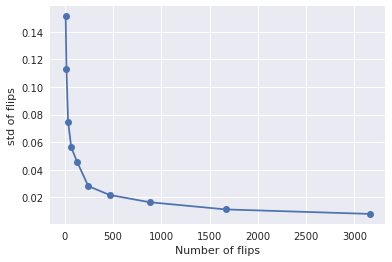

In [108]:
n_list = np.logspace(1, 3.5, 10).astype(int)
std_list = []
for N in n_list:
    flip_means = np.zeros(100)
    for i in range(100):
        flip_means[i] = np.mean(random_coin_toss(N, .5))
    std_list.append(np.std(flip_means))
plt.plot(n_list, std_list,'o-')
plt.xlabel('Number of flips')
plt.ylabel('std of flips')

This is brings us to the *null hypothesis* which says that the data does not deviate from the expected result (or is not extreme) in this case, the null hypothesis is that the coin is fair and so we would expect a mean of 0.5.  However, what if our mean is 0.51, 0.6?  We need a way to quantify the degree of *extremeness* in our result.

One such way is know as the p-value.  The p-value quantifies the probability given the null hypothesis of geting result as extreme as the data.  It can be used to assign a confidence to an assertion that the null hypothesis is not true.  

Lets assume that our coin will be biased towards heads, (for this problem, ....).  Then we can calculate the p value as the probability of the mean being larger than the value given.  Mathematically we can write this in general as 
$$p = Pr(X\geq x|H)$$

Generally speaking, people use p values of 0.05 or 0.01 as inidicators of rejection of the null hypothesis.  Remember that observed values are a function of the probability distribution and thus a small p value indicates that very little of the probability distribution can contribute to any result more extreme than this.  

Since the probability distribution of coin flips is well known, we can quantify this mathematically analytically.  Coin flips follow a Binomial distribution.

The probability of geting $k$ heads in $n$ trials with a coin that has probability $p$ is given by the Binomial distribution
$$P(X=k) = {n \choose k}p^k(1-p)^{n-k}$$
which we can sample using scipy.  Lets look at a few cases of the distribution for when the coin is biased towards heads.

first we will import the the binomial random variable class from scipy.

In [35]:
from scipy.stats import binom

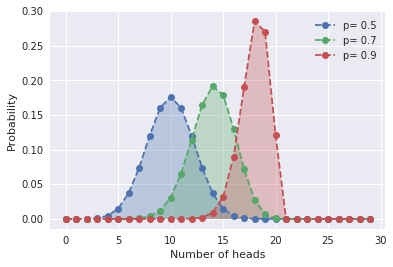

In [78]:
x = np.arange(30)
for p in [.5,.7,.9]:
    dist = binom.pmf(x,20, p)
    plt.fill_between(x, 0 , dist, alpha=.3)
    plt.plot(x, binom.pmf(x,20, p), 'o--', label='p= {}'.format(p))
plt.xlabel('Number of heads')
plt.ylabel('Probability')
plt.legend();

For a discrete distribution, we can define the $p$ value as a summation over all the other values.  For an example, lets say Mary flips the coin 100 times and gets 60 heads.  The p value can be computed as 
$$ \sum_{i=60}^{100} P(X=i|H) = \sum_{i=60}^{100} {n \choose k}\left(\frac{1}{2}\right)^k\left(1-\frac{1}{2}\right)^{n-k},$$
notice that we used $p=1/2$ as this is the probability given the null hypothesis that the coin is fair.  We can compute this easily using the binomial distribution.

In [73]:
def compute_coin_p_value(n_heads, n_tosses):
    return binom.pmf(np.arange(n_heads,n_tosses+1,1), n_tosses, 1/2).sum()

p = compute_coin_p_value(60, 100)
print("p value = {:.4f}".format(p))

p value = 0.0284


We can also plot the overall distribution as well as the portion summed over to obtain the p value.

(30, 70)

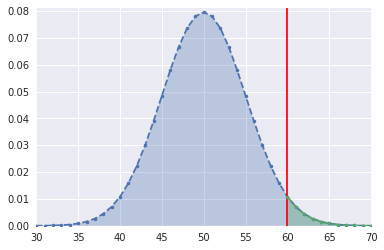

In [74]:
x = np.arange(0,100,1)
dist = binom.pmf(x, 100, 1/2)
plt.fill_between(x,0, dist, alpha=.3)
plt.plot(x, dist, '.--')
plt.axvline(60,0,1, color='red')
x2 = np.arange(60,100,1)
dist = binom.pmf(x2, 100, 1/2)
plt.fill_between(x2,0, dist, alpha=.3)
plt.plot(x2, dist, '.--')
plt.ylim(0,.081);
plt.xlim(30,70)

In [109]:
compute_coin_p_value(600, 1000)

1.3642320780338679e-10

With a p value of .0284, Mary can reject the null hypthesis at the 3 % level which would often qualify to certify the coin not biased.  Where exactly this cuttoff lies is a matter of interperetation, it is often at the 5% or 1% level.  We could also count the two-tailed p value which also considers the probability of getting less than the value, however, for a symmetric distribution, it will be twice the one side

### t distsributions

Another test we can perform is the t-test which can be written simply as 
$$ t = \frac{\mu - \mu_0}{s/\sqrt{n}},$$
where $\mu$ is the statistic under test, $\mu_0$ is the expected statistic under the null hypothesis, $s$ is the standard deviation of the sample and $n$ is the number of measurements. 

For the case of a coin, we already know the $\mu = np$ and $s=\sqrt{np(1-p}$, thus calcualting the t statistic is fairly straightforward.  The important thing about the $t$ statistic is that if follows $\nu-1$ MORE ABOUT THIS....

## Baysian Approach

So far we have looked at this problem only from the perspective of intretating the results of a set of coin flips and deciding at what level we can reject the null hypothesis.  However, there is another approach we can take which is to compute the degree to which we believe the coin is not fair.  To do this we will use Bayes' theorem

$$P(A | B) = \frac{P(B|A)P(A)}{P(B)},$$
which we can read as the probability of A given B is equal to the probability of B given A times the ratio of the probabilty of A and B independently.  To gain some intution for our current use case, we can regard A as a hypothesis and B as the event that happened.  So on the left side, we have the probability of the hypothesis, given the data.  This is equal to the probability of the event occuring given the hypothesis times the probability of the hypothesis divided by the probability of the event occuring.  These factors make sense and we can view them as 

* $P(A)$ - probability of the hypothesis, if the hypothesis is more likely in general, than it is also more likely for any given event.
* $P(B)$ - probability of the event, this is also called the marginal likelihood and it does not depend on the hypothesis.

The key point here is that the probability of the hypothesis depends on some prior belief about what happens.

So now we can return to the problem at hand.  Here A is the null hypothesis being valid (or the binomial distribution has $p=1/2$) and B is getting 60 heads out of 100 tosses.  $P(A)$ is the prior belief in the hypothesis (more on this in a sec), $P(B|A)$ is a binomial distribution, but how do we get $P(B)$?.  We can write this probability as an integral over the possible values of $A$
$$ P(B) = \int P(B|A')P(A')dA'.$$
In general, this is quite a hard integral to solve analytically and in most cases, we would need to resort to high dimensional numerical integrals or other methods to get this.  However, we can be crafty about our choice of $P(A)$ to get a function will will give an anaytic result for this integral.  This specific prior is generally called the conjugate prior and exists for only a certain class of distributions.  For the case of a binomial distribution, the proper conjugate prior is the Beta distribution.  As one might guess, the conjugate prior for the normal distribution is a normal distribution.

Remember that these distributions have parameters and we are still able to encode information about prior knowledge by adjusting these parameters.

Lets plot the beta distribution for a set of variables, in this case $\alpha,\beta$ are the two relevent parameters.

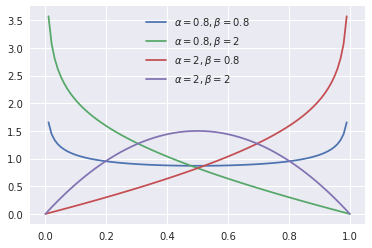

In [104]:
from scipy.stats import beta
x = np.linspace(0,1,100)
for alpha in [.8,2]:
    for beta_ in [.8,2]:
        plt.plot(x, beta.pdf(x,alpha,beta_), label=r'$\alpha={},\beta={}$'.format(alpha,beta_))
plt.legend()

In our case, we think that the distribution is fair, so we will choose $\alpha=\beta=2$.  Putting all this together, we can compute the exact expression for the posterior as 
$$P(A|B) = \frac{(1/2)^{61}*(1/2)^{41}}{B(62, 42)} $$
where $B$ is the beta function, which is itself a beta function!  This can be analytically derived, but we will not show a derivation here.  So we can plot the distribution which we expect as 

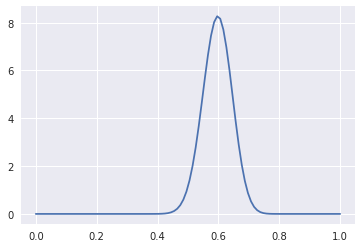

In [107]:
x = np.linspace(0,1,100)
p = beta.pdf(x, 62, 42)
plt.plot(x, p)

Now, this distribution gives us for any value the probability of the hypothesis, given the data, in particular, we can look at the probability of the coin being fair, which is quite low. 

Now, what if we forget how to integrals and don't remember the formula for the Beta distribution, or we have have a problem which does not permit a conjugate prior.  Then we can resort to numerical methods to sample the denomantor which are generally referred to as poster sampling and usually performed using monte carlo methods. 

Luckily, there is a great python package to do this, pymc3.  Her we can choose the prior (we will choose the right one here so we can check the analytic result) and draw from the posterior distribution

In [132]:
import pymc3 as pm

In [175]:
with pm.Model():
    p = pm.Beta('p', alpha=2, beta=2)
    y = pm.Binomial('y', n=100, p=p, observed=60)
    trace = pm.sample(20000)
sampled = trace[p][1000:]

/home/zachglassman/miniconda3/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -4.2678: 100%|██████████| 200000/200000 [00:10<00:00, 19073.09it/s]
Finished [100%]: Average ELBO = -4.2626
100%|██████████| 20000/20000 [00:05<00:00, 3808.98it/s]


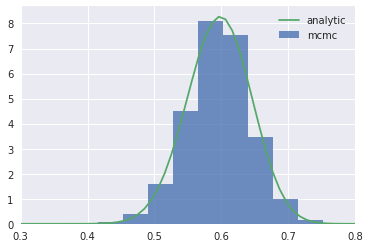

In [176]:
plt.hist(sampled, normed=True,alpha=.8,label='mcmc')
p = beta.pdf(x, 62, 42)
plt.plot(x, p, label='analytic')
plt.xlim(.3,.8)
plt.legend()

## Comparison 
We have presented two general methods for testing hypothesis, they each have their strenghts and weaknesses.

The biggest strength of the Baysian analysis is its straightforward interpretation of the hypothesis being true.  It directly lets us access this.  However, it requires we choose a prior which is a somewhat aribtrary choice.

### References

1.https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading20.pdf